# **Predicting Bike Sharing Demand**

This project aims to find the most accurate method of predicting bike sharing demand using the Bike Sharing Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) ([link to dataset here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)). I will be using \_insert methods here\_ going from a simple, basic, "no work" predictor to use as baseline, and work our way up by engineering features, or trying more and more sophisticated predicting methods.

#### **A few words about the data:**
This data is all about bike sharing demand in the [Capital Bikeshare](https://www.capitalbikeshare.com/) program in Washington, D.C and can prove useful in studying mobility in a city. In short, bike sharing systems operate through a network of kiosk locations all throughout a city generally via memberships. If you live in a major city, chances are you either are familiar with these networks or even using one. For example, in my hometown (Bucharest, Romania) we have at least two private bike sharing services and a few public ones that operate usually within parks. These systems allow people to rent a bike from one docking point and return it to any other docking point, which makes them a viable alternative to public transport or driving, as well as a great way to enjoy a sunny day in the park. As the [UCI dataset](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) page mentioned, at the time of writing, there were over 500 bike-sharing programs around the world.

#### **Business case:**  
Rental services are paid, so as a rental service company, one of your concerns is customer satisfaction. Predicting bike rental demand helps adjust supply, especially if it can be done a few days in advance. The big problem with early prediction is that it converges to the task of predicting weather, a task which is notoriously difficult (as outlined, among other sources, by this [article](https://letstalkscience.ca/educational-resources/stem-in-context/why-weather-so-hard-predict), or in [Nate Silver's book "The Signal and the Noise"](https://www.goodreads.com/book/show/13588394-the-signal-and-the-noise?from_search=true&from_srp=true&qid=jxBgJ9qJk1&rank=1)).
That aside, making sure customers have a bike available when they need it ensures they are satisfied with the service and will therefore avoid any bad reviews and maintain reputation.

#### **Importing Standard libraries**

In [1]:
# std libraries
import os
import tarfile
import urllib
from zipfile import ZipFile

# data processing libraries
import numpy as np
import pandas as pd

# to avoid sklearn warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# ml modeling libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#### **Fetching data locally and reading it into a dataframe**

In [2]:
# Create download variables (url, path to download to)
DOWNLOAD_ROOT = "http://archive.ics.uci.edu/ml/"
DATA_PATH = os.path.join("data")
DATA_URL = DOWNLOAD_ROOT + "machine-learning-databases/00275/Bike-Sharing-Dataset.zip"

In [3]:
def fetch_data(data_url=DATA_URL, data_path=DATA_PATH):
    os.makedirs(data_path, exist_ok=True)
    zip_path = os.path.join(data_path, "Bike-Sharing-Dataset.zip")
    urllib.request.urlretrieve(data_url, zip_path)
    with ZipFile(zip_path, 'r') as data_zip:
        files = data_zip.namelist()
        data_zip.extractall(DATA_PATH) 
        data_zip.close()
    return files

In [4]:
file_names = fetch_data()
print(file_names)

['Readme.txt', 'day.csv', 'hour.csv']


In [5]:
DATA_CSV = os.path.join(DATA_PATH, "hour.csv")

In [6]:
df = pd.read_csv(DATA_CSV)
print("No. of observations:", df.shape[0])
print("No. of columns:", df.shape[1])

No. of observations: 17379
No. of columns: 17


#### **How we will be Evaluating Performance: Cross Validation**
Usually, we would split our data into train and test right at the start and perform exploratory data analysis (EDA) only on the train set. This helps us have a more accurate image of the models performances and we can remain unbiased during the training phase.

But for this project we will be using **Cross Validation**, and as such we will explore the entire data set, perform the necessary transformations and cross-validate for each model we try out.

We will split data into training and test only for the purpose of visualizing the relationship between predictions and target values (not to distort the relationship).

In [7]:
print(df.info())
print("\n","Dataset sample:")
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB
None

 Dataset sample:


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


We have no missing values, which helps us cut a lot on the pre-work

In [8]:
df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


#### **Analyze fatures and target correlations**
Correlations help us avoid some modeling pitfalls (colinearity, target leaks, etc).  
We'll take a look at what features are strongly correlated and remove the appropriate ones to avoid colinearity.  
Also, we'll see which features correlate with the target which helps us 1/ select good predictors and 2/ remove target leaks.

In [9]:
def plot_correlation_heatmap(df, rounding=2, fig_width=18, fig_height=15, title="Correlation Matrix", title_size=16):
    # Calculate the correlation matrix and round to two decimal points
    corr = df.corr().round(rounding)
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(fig_width, fig_height))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 220, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    # Set heatmap plot title
    plt.title(title, fontsize=title_size)

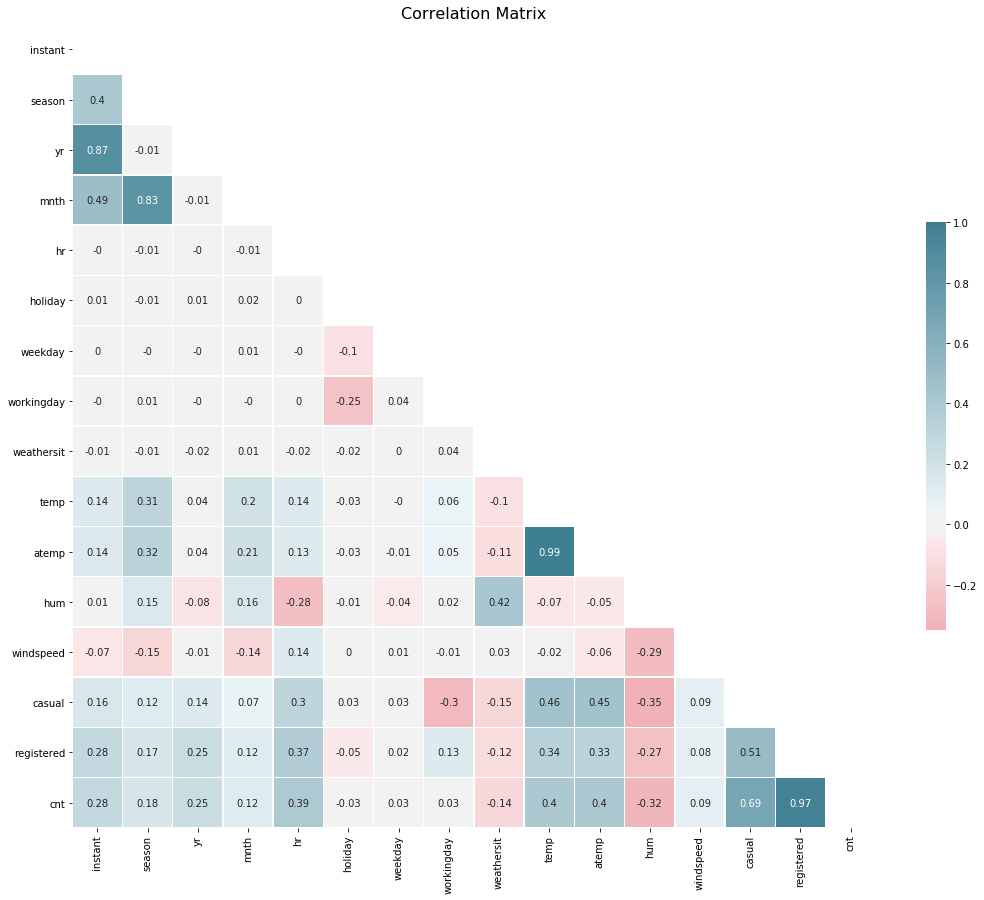

In [10]:
plot_correlation_heatmap(df)

# Show the plot
plt.show()

#### **Correlation conlusions**

* It seems that our target variable "cnt" is positively correlated with hour (hr) and temperature (temp/atemp) and negatively correlated with weather (weathersit) and humidity (hum). This is intuitive, as few people go out on bike rides between 12AM and 6AM, and usually people opt for bike rides in higher temperatures and better weather.

* temp and atemp are highly correlated. we will choose one further down, to see if there are any data anomalies to take into consideration.

* registered and casual are strongly correlated with cnt, and that is because casual + registered = cnt. We will check this below.

#### **Feature Selection**

What we won't use as features:
- instant (ID column - not descriptive)
- year (not reproducible)
- mnth (interchangeable with season)
- atemp (interchangeable with temp)
- registered (leak from the future)
- casual (leak from the future)

What we will use as features:
- season
- hr
- holiday
- weekday
- workingday
- weathersit
- temp
- hum
- windspeed

Target variable:
- cnt

Now we'll test wether casual + registered equals cnt or not.

In [11]:
test_count = df['casual'] + df['registered'] == df['cnt']
assert test_count.sum() == len(test_count)

It does.

#### **Histogram grid analysis**
Assessing how our features are distributed to get an idea of each variable's meaning in the context of bike rentals and look for possible outliers.  
Here we can assess what type of distribution each feature has (uniform, normal, exponential, etc.) and what variability we are dealing with.

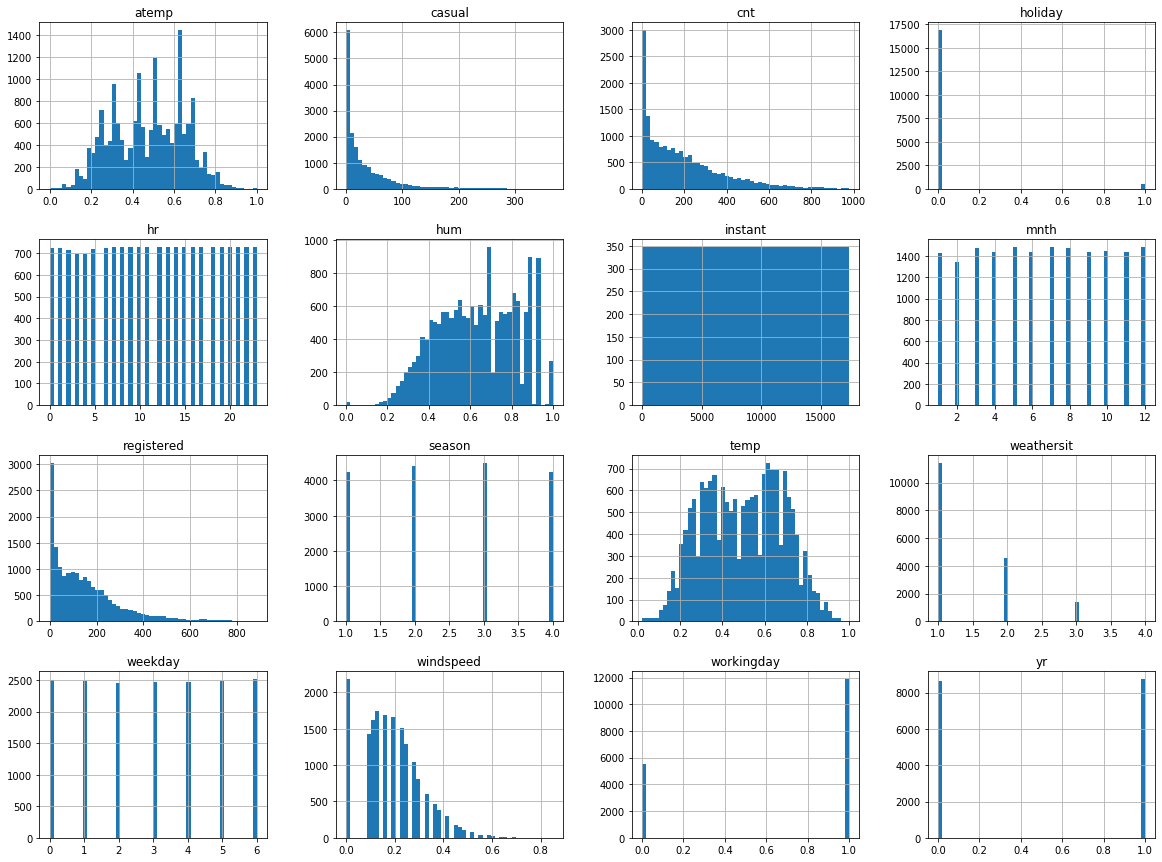

In [12]:
df.hist(bins=50, figsize=(20,15))
plt.show()

##### **Histogram analysis conclusions**

- Our target variable 'cnt' seems to have an exponential distribution, meaning we have a lot of hours with very few rentals, and a few instances with a very high amount of rentals. This pattern is true for both components of 'cnt', 'registered' and 'casual'.

- Temperature (temp) looks like two overlapped normal distributions, which may be caused by the seasons fluctuations of temperatures across the year.

- Humidity (hum) seems to follow a normal distribution, with a strong skewness towards the left (we have a considerable number of extremely high humidity cases).

- Instant (instant) is the row id so it makes sense for it to follow a uniform distribution. We won't be using it in modeling, but knowing the row ids look consistent is a good sign.

#### **Feature-targets relationships analysis**

In [13]:
# Separating features from targets for relationship analysis
features = ['season', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed']
targets = ['casual', 'registered', 'cnt']

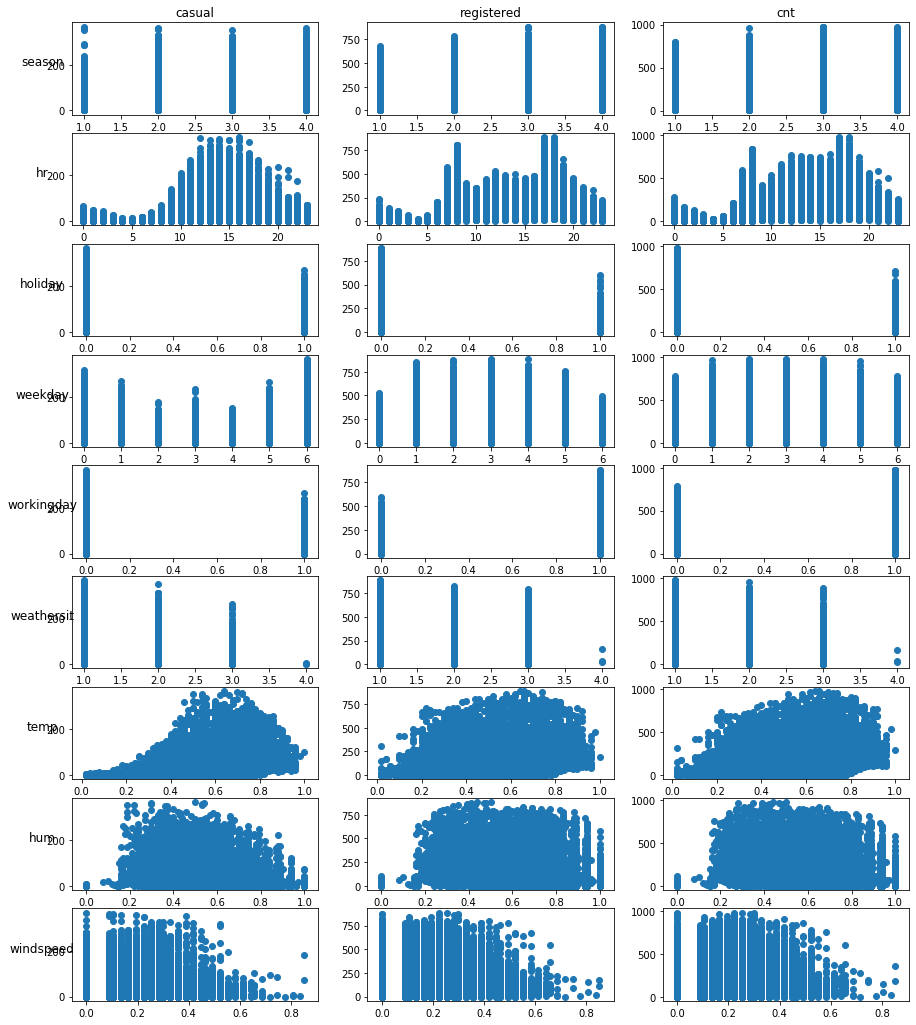

In [14]:
# Create a plot containing scatterplots between each feature and each target
figure, axes = plt.subplots(figsize=(15, 18), nrows=len(features), ncols=len(targets))

for feat_num, feature in enumerate(features):
    for target_num, target in enumerate(targets):
        axes[feat_num, target_num].scatter(df[feature], df[target])
        
for ax, target in zip(axes[0], targets):
    ax.set_title(target)

for ax, feature in zip(axes[:,0], features):
    ax.set_ylabel(feature, rotation=0, size='large')

plt.show()

##### **Feature relationship analysis conclusions**

There are very different relationships between features and the three potential targets.
- rentals have very different patterns with regards to **weekday and hour** relationship to rentals is widely different if we're comparing casual vs registered rentals. It seems registered uses are strongly related to work days (days 1-5), meaning people use this service on a schedule to get to/from work. In contrast, casual rentals are mostly during weekend (days 0 and 6). As for hours, we can see spikes of registered rentals around the 9AM and 5PM marks, confirming people use registered rentals to go to/from work.
- casual rentals is more strongly influenced by **temperature and humidity**, with a lower number of rentals at lower temperatures. Registered rentals are not affected as much (assuming people need to go to work, regardless of weather), and therefore neither is our main target variable.

#### **Data Cleaning**

Now it's time to prepare the features for modelling. Top tasks to do:
- resolve colinearity issue between temp and atemp
- weekday (transform into boolean)
- weathersit (one hot encoding)

##### **Check colinearity between temp and atemp variables**

We've seen that temp and atemp are highly correlated (0.99) so we need to check the relationship for anomalies and see which of the features to keep.

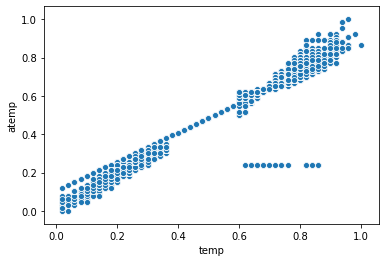

In [15]:
ax = sns.scatterplot(x="temp", y="atemp", data=df)

It seems we have some anomalous values - values where atemp seems to have a value of about 0.22 but temp has values between 0.6 and 0.9. We should remove these observations.

In [16]:
temp_mask = (df['temp'] > 0.6) & (df['temp'] < 0.9)
atemp_mask = (df['atemp'] > 0.15) & (df['atemp'] < 0.3)
anomalous_df = df[temp_mask & atemp_mask]
anomalous_df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
14131,14132,2012-08-17,3,1,8,0,0,5,1,1,0.68,0.2424,0.57,0.1642,21,67,88
14132,14133,2012-08-17,3,1,8,1,0,5,1,1,0.66,0.2424,0.65,0.1045,16,38,54
14133,14134,2012-08-17,3,1,8,2,0,5,1,1,0.66,0.2424,0.61,0.1343,4,15,19
14134,14135,2012-08-17,3,1,8,3,0,5,1,1,0.64,0.2424,0.65,0.1045,0,6,6
14135,14136,2012-08-17,3,1,8,4,0,5,1,1,0.64,0.2424,0.73,0.1642,0,9,9
14136,14137,2012-08-17,3,1,8,5,0,5,1,1,0.64,0.2424,0.73,0.1045,2,34,36
14137,14138,2012-08-17,3,1,8,6,0,5,1,1,0.62,0.2424,0.78,0.1343,6,151,157
14138,14139,2012-08-17,3,1,8,7,0,5,1,1,0.64,0.2424,0.73,0.1045,11,368,379
14139,14140,2012-08-17,3,1,8,8,0,5,1,1,0.68,0.2424,0.65,0.1343,43,625,668
14140,14141,2012-08-17,3,1,8,9,0,5,1,1,0.70,0.2424,0.58,0.1045,58,320,378


We have uncovered an error with atemp, which has for a few values of temp a fixed value of 0.2424.
We can therefore remove atemp and use temp, to avoid these errors. This would have minimal to no impact, given temp and atemp are highly correlated.

In [17]:
clean_df = df[~(temp_mask & atemp_mask)]

##### **Transform weekday into int**|

In [18]:
# create is_weekend = 1 if weekday is Saturday (6) or Sunday (0)
clean_df['is_weekend'] = clean_df['weekday'].isin([0,6]).astype(int)

##### **Transform weathersit using one hot encoding**

In [19]:
clean_df['weathersit'] = clean_df['weathersit'].astype(str)
# Get one hot encoding of columns B
one_hot = pd.get_dummies(clean_df[['weathersit']])
# Join the encoded df
clean_df = clean_df.join(one_hot)
# Drop column as it is now encoded and drop last dummy variable to avoid multicollinearity
clean_df = clean_df.drop(['weathersit', 'weathersit_4'], axis = 1)

In [20]:
features = ['season', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit_1', 'weathersit_2', 'weathersit_3', 'temp', 'hum', 'windspeed']
target = ['cnt']

Next steps:

* Fortunately for us, this data has been cleaned beforehand. But, if we want to deploy these models into production, we need to connect them to the real-time data source(s), and create pipelines that clean and transform the data to match the format we used to create these models.

* One other big concern is having enough bikes in the right docking stations at the right times. The data at hand won't help us predict this, but it's a great task to pursue given that mobility data is available on [Capital Bikeshare's website](https://s3.amazonaws.com/capitalbikeshare-data/index.html). Unfortunately there's no financial data on how costly it is to frequently move bikes to the right docking stations, but that can be estimated.

## **Model Selection**  
Our data is ready for modelling so we can get into testing a few models, see which one performs best, and use it for future predictions.
The **performance metric** will be RMSE (root meansquared error) across our models to assess which one performs the best.

### **Approach 1: use 'cnt' ad target**

We will be trying out a few regression models:
1. Linear Regression
2. Decision Tree Regression
3. Random Forrest Regression
4. Bagging Regression
5. Gradient Boosting Regression
6. Support Vector Regressor

We'll create a dataframe to store the results of each model and plot a boxplot at the end, to aid us in selection.

In [21]:
# Empty dataframe that will store the results for each model    
models_results = pd.DataFrame()

#### **Linear Regression**

In [22]:
# Measure & record model performance
lr = LinearRegression() # linear regression does not have a random_state parameter

lr_scores = cross_val_score(lr, clean_df[features], clean_df[target], cv=5, scoring='neg_mean_squared_error')
lr_scores = np.sqrt(-lr_scores)
models_results['LR'] = lr_scores
print("Accuracy: %0.2f (+/- %0.2f)" % (lr_scores.mean(), lr_scores.std() * 2))

Accuracy: 155.86 (+/- 68.62)


We are on average 144 bike rentals off - not great, as it is almost one standard deviation from the mean. This quite a lot, so let's find a way to improve this model.

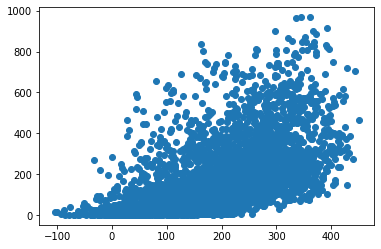

In [23]:
# Split data into tran/test to visualize the relationship between predictions and targets
train_df, test_df = train_test_split(clean_df, test_size=0.2, random_state=42)

# Plotting the relationship between predictions and the target variable (should be a straight diagonal line)
lr.fit(train_df[features], train_df[target])
lr_predictions = lr.predict(test_df[features])
plt.scatter(lr_predictions, test_df['cnt'])
plt.show()

This cloud should look a lot more like a straight diagonal line, with no values below zero.
So we need to find a way to make better predictions. Linear regression will not cut it, but now we have a base.
Let's try a decision tree.

#### **Decision Tree Regression**

In [24]:
# Measure & record model performance
dtr = DecisionTreeRegressor(random_state=42)
dtr_scores = cross_val_score(dtr, clean_df[features], clean_df[target], cv=5, scoring='neg_mean_squared_error')
dtr_scores = np.sqrt(-dtr_scores)
models_results['DT'] = dtr_scores
print("Accuracy: %0.2f (+/- %0.2f)" % (dtr_scores.mean(), dtr_scores.std() * 2))

Accuracy: 123.51 (+/- 17.74)


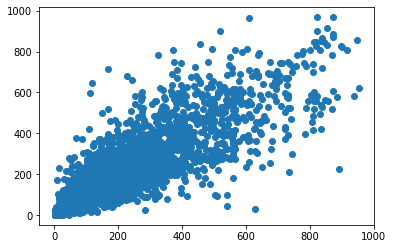

In [25]:
# Plotting the relationship between predictions and the target variable (should be a straight diagonal line)
dtr.fit(train_df[features], train_df[target])
dtr_predictions = dtr.predict(test_df[features])
plt.scatter(dtr_predictions, test_df['cnt'])
plt.show()

The decision tree regression faired considerably better, cutting a third of the error. It also didn't predict any negative values (as seen in the graph) which is encouraging. What still seems to not work is the fact that the values are still highly dispersed, especially on the upper half of the values.  
Let's now go ahead and try an ensemble method, specifically a Random Forest Regressor.

#### **Random Forest Regression**

In [26]:
# Measure & record model performance
rfr = RandomForestRegressor(random_state=42)
rfr_scores = cross_val_score(rfr, clean_df[features], clean_df[target], cv=5, scoring='neg_mean_squared_error')
rfr_scores = np.sqrt(-rfr_scores)
models_results['RF'] = rfr_scores
print("Accuracy: %0.2f (+/- %0.2f)" % (rfr_scores.mean(), rfr_scores.std() * 2))

Accuracy: 107.85 (+/- 20.13)


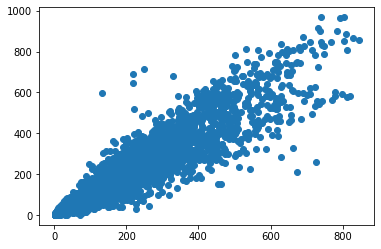

In [27]:
# Plotting the relationship between predictions and the target variable (should be a straight diagonal line)
rfr.fit(train_df[features], train_df[target])
rfr_predictions = rfr.predict(test_df[features])
plt.scatter(rfr_predictions, test_df['cnt'])
plt.show()

As we can see, there is quite an improvement still, reducing the error by about 53% versus our linear regression. The dispersion shown in the decision tree is also reduced. We can try to further improve the model with a bagging method, or gradient boosting.  
Let's try both of them out. 

#### **Bagging Regression Tree**

In [28]:
# Measure & record model performance
br = BaggingRegressor(random_state=42)
br_scores = cross_val_score(br, clean_df[features], clean_df[target], cv=5, scoring='neg_mean_squared_error')
br_scores = np.sqrt(-br_scores)
models_results['Bagging'] = br_scores
print("Accuracy: %0.2f (+/- %0.2f)" % (br_scores.mean(), br_scores.std() * 2))

Accuracy: 109.52 (+/- 20.20)


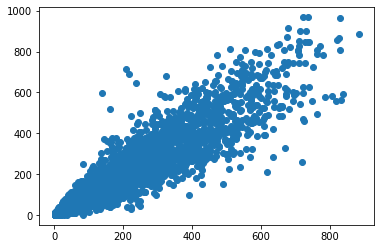

In [29]:
# Plotting the relationship between predictions and the target variable (should be a straight diagonal line)
br.fit(train_df[features], train_df[target])
br_predictions = br.predict(test_df[features])
plt.scatter(br_predictions, test_df['cnt'])
plt.show()

#### **Gradient Boosting Regression**

In [30]:
# Measure & record model performance
gbr = GradientBoostingRegressor(random_state=42)
gbr_scores = cross_val_score(gbr, clean_df[features], clean_df[target], cv=5, scoring='neg_mean_squared_error')
gbr_scores = np.sqrt(-gbr_scores)
models_results['Gradient'] = gbr_scores
print("Accuracy: %0.2f (+/- %0.2f)" % (gbr_scores.mean(), gbr_scores.std() * 2))

Accuracy: 111.93 (+/- 39.78)


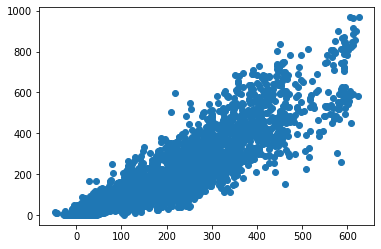

In [31]:
# Plotting the relationship between predictions and the target variable (should be a straight diagonal line)
gbr.fit(train_df[features], train_df[target])
gbr_predictions = gbr.predict(test_df[features])
plt.scatter(gbr_predictions, test_df['cnt'])
plt.show()

This is interesting, it seems neither sampling with replacement (bagging) nor improving on preceding models (gradient boosting) helped reduce prediction error. Up until now our best option is indeed the Random Forrest. Let's try one last thing before we move onto other ways to improve the accuracy: SVMs.

#### **Support Vector Regression**

In [32]:
# Measure & record model performance
svr = SVR() # SVR does not have a random_state parameter
svr_scores = cross_val_score(svr, clean_df[features], clean_df[target], cv=5, scoring='neg_mean_squared_error')
svr_scores = np.sqrt(-svr_scores)
models_results['SVR'] = svr_scores
print("Accuracy: %0.2f (+/- %0.2f)" % (svr_scores.mean(), svr_scores.std() * 2))

Accuracy: 150.28 (+/- 97.42)


Wow, so the SVM performed even worse than our baseline model. Quite a surprise.  
Let's check out the scatterplot to see if the algorithm is making any systematic errors, or if it's just bad at predicting on this problem.

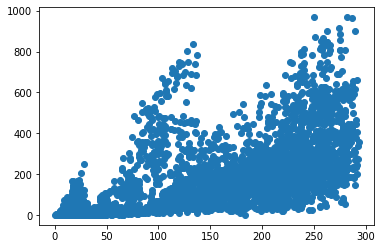

In [33]:
# Plotting the relationship between predictions and the target variable (should be a straight diagonal line)
svr.fit(train_df[features], train_df[target])
svr_predictions = svr.predict(test_df[features])
plt.scatter(svr_predictions, test_df['cnt'])
plt.show()

Indeed the SVM is all over the place. It looks like it's modelling the noise more than the signal.
We have a clear winner: Random Forest!
Now let's try to improve that further.

#### **Approach 1 Summary**

Based on the boxplot below we can conclude that the best performing model is the Random Forrest, although it is in close tie with the bagging model.  
The Gradient Boosting Regression has better performance on the lower end, but the variability makes it a less desirable candidate.  
In the end, we will be using the Random Forrest regression, as it is also more interpretable, and we do not compromise on performance.  

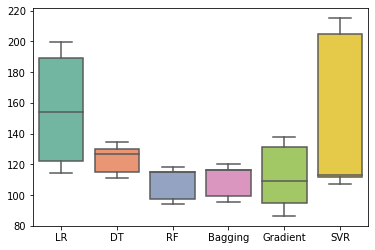

In [34]:
sns.boxplot(data=models_results, palette="Set2")
plt.show()

### **Approach 2: Splitting the targets**

Here we will use the best performer in the first approach and see if it performs even better if we have a split target approach.

In this case, to test out or method, I will use the train/test split and validate results. With CV it would be slightly more complicated to measure performance on two parallel models.

We've seen above that there are some differences between the casual and registered counts and their relationships with the feature variables.
It would make sense to try and see if we build two different models, one to predict each number, it would improve the overall prediction. Our target now is to get a better result that the Random Forrest regressor.

In [35]:
casual_target = 'casual'

# Instantiating and fitting a Random Forrest Regressor on the casual dataset
rfr_casual = RandomForestRegressor(random_state=42)
rfr_casual_scores = cross_val_score(rfr_casual, clean_df[features], clean_df[target], cv=5, scoring='neg_mean_squared_error')
rfr_casual_scores = np.sqrt(-rfr_casual_scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (rfr_casual_scores.mean(), rfr_casual_scores.std() * 2))

Accuracy: 107.85 (+/- 20.13)


In [36]:
# Split data into tran/test to visualize the relationship between predictions and targets
train_df, test_df = train_test_split(clean_df, test_size=0.2, random_state=42)

In [37]:
# Print out feature importance for casual rentals
rfr_casual.fit(train_df[features], train_df[casual_target])
rfr_casual_fi = pd.Series(rfr_casual.feature_importances_, index = features)
rfr_casual_fi.sort_values(ascending=False)

hr              0.375456
temp            0.241935
workingday      0.202213
hum             0.087355
windspeed       0.035823
weekday         0.022700
season          0.019701
weathersit_1    0.004458
holiday         0.003707
weathersit_2    0.003391
weathersit_3    0.003260
dtype: float64

In [38]:
registered_target = 'registered'

# Instantiating and fitting a Random Forrest Regressor on the registered dataset
rfr_registered = RandomForestRegressor(random_state=42)
rfr_registered_scores = cross_val_score(rfr_registered, clean_df[features], clean_df[target], cv=5, scoring='neg_mean_squared_error')
rfr_registered_scores = np.sqrt(-rfr_registered_scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (rfr_registered_scores.mean(), rfr_registered_scores.std() * 2))

Accuracy: 107.85 (+/- 20.13)


In [39]:
# Print out feature importance for registered rentals
rfr_registered.fit(train_df[features], train_df[registered_target])
rfr_registered_fi = pd.Series(rfr_registered.feature_importances_, index = features)
rfr_registered_fi.sort_values(ascending=False)

hr              0.577019
temp            0.123636
workingday      0.114935
hum             0.063920
windspeed       0.036108
season          0.033735
weekday         0.023455
weathersit_3    0.015758
weathersit_1    0.005161
weathersit_2    0.003515
holiday         0.002759
dtype: float64

Now let's append the average of casual and registered to the results table and compare.  
(Normally I know this is not the correct way of comparing the results, but it's a quick and dirty proxy to get the general idea).

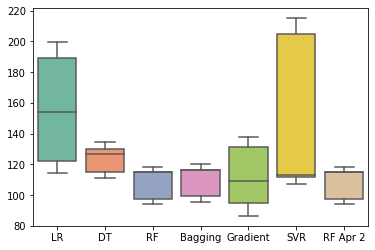

In [40]:
models_results['RF Apr 2'] = (rfr_casual_scores + rfr_registered_scores) / 2
sns.boxplot(data=models_results, palette="Set2")

#### **Approach 2 Summary**
While it seems the second approach has great performance, and very low variability, it is not noticeably better than the Random Forrest regressor.  
Given that it leverages 2 models to make its predictions, I think we can stick to our basic Random Forrest.

### **Summary**

In our pursuit to find the best predictive model to help us assess the rental needs on a hourly basis, we have tested 7 models in 2 different approaches.  
We have found that for this problem, the Random Forrest regressor is the best option, without having to use two predictors.

There are of course a lot of models we have not tried out that might merit a try (for example, maybe a deep learning regressor would be more accurate than any of the models here. who knows?).

#### _To conclude, if we are to ensure customer satisfaction by having a bike available when they need it, the Random Forrest model would be our best option!_

#### **What else can we try?**
##### PCA - we could compress the dataset to select fewer variables while maintaining model performance. This comes in incredibly handy when we want to optimize the amount of data that is streamed around.

In [41]:
x = train_df.loc[:, features].values# Separating out the target
y = train_df.loc[:, target].values# Standardizing the features
x = StandardScaler().fit_transform(x)

In [42]:
pca = PCA(n_components=10)
pca.fit(x)
print(pca.explained_variance_ratio_)

[0.19745888 0.130958   0.11890846 0.11330518 0.10780326 0.08911755
 0.07415736 0.06735129 0.05830787 0.04261891]


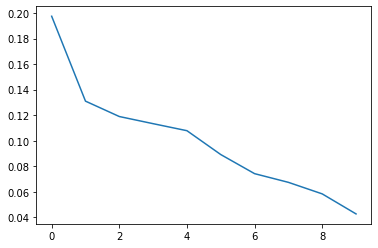

In [43]:
plt.plot(pca.explained_variance_ratio_)

This is a tricky situation - it seems there is no clear "elbow" in the graph to help us select the number of features to keep and still have a satisfactory level of variability kept.  
PCA in this case would require more work, but I will leave it at this for now.

___

Thank you for reading this notebook. I hope it provided inspiration for your data science projects.  
If you find anything in this that could be improved, I'd love some feedback at gradinaru.alex@gmail.com.